# Импорты

In [403]:
import numpy as np
import pandas as pd
import scipy.stats as st
from typing import Union
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# Загрузка исходных данных

In [2]:
all_data = pd.read_excel('data/Задачи для кандидатов.xlsx', sheet_name='Data')
all_data = all_data.drop(['index'], axis='columns')

display(all_data.head())
print(all_data.shape)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,target
0,10.528055,0.308325,1154.451034,0.147287,0.854394,4.483094,9.894689,28.741196,389.133299,0.000000,...,12.143896,10.328332,1.756277,32.440867,4.767277,25.931299,67.881356,7.790180e+06,7.297312e+02,0
1,8.932895,0.000000,1321.542631,0.189447,0.854394,4.483094,11.543803,11.676111,391.040816,1.286672,...,14.572675,10.328332,8.781386,571672.962983,14.301832,185.223564,3256.042367,8.722124e+06,2.949072e+07,1
2,6.460397,0.308325,1184.831324,0.136356,3.417574,4.483094,7.146164,15.268760,495.000447,0.000000,...,12.143896,5.901904,1.756277,0.000000,38.138219,1196.544226,730.855931,6.396224e+05,0.000000e+00,0
3,14.675470,1.849952,0.000000,0.127774,5.980755,10.759425,8.795279,31.435683,980.463313,82.346987,...,19.430234,1.475476,1.756277,16.220434,0.000000,25.931299,15.838983,4.024388e+07,1.060543e+03,0
4,6.938945,1.849952,0.000000,0.114831,0.854394,5.977458,7.695869,110.473971,768.729018,128.667167,...,4.857558,0.000000,1.756277,16.220434,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0


(37163, 24)


# Анализ исходных данных

## Типы данных

Посмотрим на тип данных в каждой из колонок

In [3]:
all_data.dtypes

x_0       float64
x_1       float64
x_2       float64
x_3       float64
x_4       float64
x_5       float64
x_6       float64
x_7       float64
x_8       float64
x_9       float64
x_10      float64
x_11      float64
x_12      float64
x_13      float64
x_14      float64
x_15      float64
x_16      float64
x_17      float64
x_18      float64
x_19      float64
x_20      float64
x_21      float64
x_22      float64
target      int64
dtype: object

## Дубликаты объектов

Проверим на наличие дубликатов наши данные

In [8]:
print('Количество дубликатов: {}'.format(all_data.duplicated().sum()))

Количество дубликатов: 0


Отлично, дубликаты отсутствуют

## Пропуски данных и количество уникальных значений

Посмотрим на количество пропущенных данных в каждой из колонок и на количество уникальных значений.

In [9]:
missing_values = pd.DataFrame({
    'nan_quantity': all_data.isna().sum(axis=0), 
    'nan_percentage': (all_data.isna().mean(axis=0) * 100).astype('int'),
    'nunique': all_data.nunique()
})
missing_values = missing_values.sort_values(ascending=False, by=['nan_quantity'])

display(missing_values)

,nan_quantity,nan_percentage,nunique
x_11,22728,61,13978
x_5,7504,20,495
x_10,5363,14,20553
x_22,1526,4,624
x_21,1526,4,12765
x_20,401,1,2987
x_19,401,1,2101
x_18,401,1,92
x_17,401,1,19
x_16,401,1,30


Также интересно посмотреть на то, как пропущенные данные распределены по классам

In [10]:
missing_values_by_class = all_data.groupby(by='target').apply(lambda col: col.isna().sum()).transpose()
missing_values_by_class[(missing_values_by_class != 0).any(axis=1)]

target,0,1
x_5,7453,51
x_10,5212,151
x_11,22248,480
x_12,25,7
x_13,390,2
x_14,390,2
x_15,390,2
x_16,399,2
x_17,399,2
x_18,399,2


На первый взгляд нет явного признака того, что для разных классов разное соотношение пропусков данных

Также есть предположение, что 0-вые значения также являются пропусками

In [11]:
missing_values = pd.DataFrame({
    'zero_quantity': (all_data == 0).sum(axis=0), 
    'zero_percentage': ((all_data == 0).mean(axis=0) * 100).astype('int'),
    'nunique': all_data.nunique()
})
missing_values = missing_values.sort_values(ascending=False, by=['zero_quantity'])

display(missing_values)

,zero_quantity,zero_percentage,nunique
target,36493,98,2
x_2,22237,59,174
x_18,19894,53,92
x_17,15048,40,19
x_19,14804,39,2101
x_22,12322,33,624
x_21,11938,32,12765
x_20,8086,21,2987
x_16,3428,9,30
x_15,3016,8,171


И по классам

In [12]:
missing_values_by_class = all_data.groupby(by='target').apply(lambda col: (col == 0).sum()).transpose()
missing_values_by_class[(missing_values_by_class != 0).any(axis=1)]

target,0,1
x_0,32,0
x_1,680,138
x_2,22142,95
x_8,181,8
x_9,1730,72
x_10,2883,40
x_13,15,0
x_14,1944,21
x_15,2970,46
x_16,3385,43


## Анализ целевой переменной

Посмотрим, как распределена целевая переменная (колонка **target**)

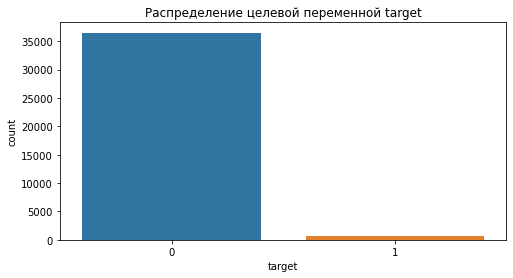

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=all_data, x='target', ax=ax)
ax.set_title('Распределение целевой переменной target');

По данному графику можно отметить существенный дисбаланс классов

## Связь данных с целевой переменной

Отобразим связь целевой переменной с данными, а также их распределение

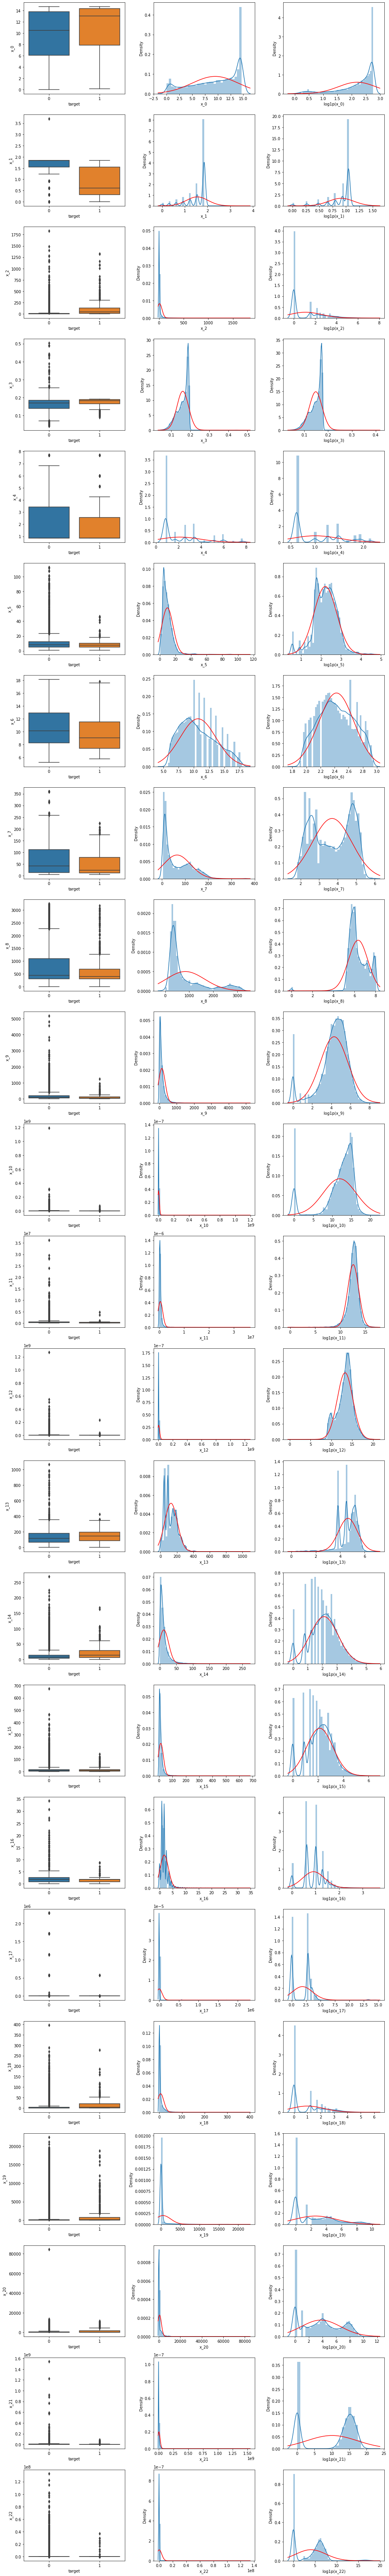

In [9]:
features = all_data.columns[all_data.columns != 'target']
nrows = len(features)
fig, ax = plt.subplots(ncols=3, nrows=nrows, figsize=(14, 4*nrows))
for i, feature in enumerate(features):
    sns.boxplot(x='target', y=feature, data=all_data, ax=ax[i, 0])
    sns.distplot(a=all_data[feature], fit=st.norm, fit_kws={"color":"red"}, ax=ax[i, 1])
    sns.distplot(
        a=np.log1p(all_data[feature]), fit=st.norm, fit_kws={"color":"red"}, ax=ax[i, 2], 
        axlabel='log1p({})'.format(feature))
fig.tight_layout();

Итак, что можно сказать по этим диаграммам:
- многие колонки содержат в себе 0-ые значения, помимо "нормальных" значений. Скорее всего это пропуск в данных или нет информации по этим данным. К таким колонкам  относятся: x_8, x_9, x_10, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22.
- с помощью применения операции логарифмирования, удалось привести данные к нормальному виду в следующих колонках (без учета нулевых значений): x_5, x_6, x_9, x_10, x_11, x_12, x_14, x_15, x_21, x_22.
- колонка x_1 неплохо коррелирует с целевой переменной. Все значения в этой колонке кратны числу 0.308325. Всего 8 уникальных значений, похоже на категориальную переменную.
- все значения в колонке x_2 кратны числу 3.79753629. Всего 174 уникальных значения.
- все значения в колонке x_4 кратны числу 0.85439355. Всего 9-ть уникальных значений. Похоже на категориальную переменную.
- колонка x_7. Все значения кратны числу 0.8981623. Всего 288 уникальных значения. После логарифмирования значений выделились два пика. Возможно стоит эту переменную заменить на бинарную (в случае использования линейных моделей).
- колонка x_8. Все значения кратны числу 0.953758085. Всего 2823 уникальных значения.
- все значения в колонке x_14 кратны числу 1.21438962. Всего 131 уникальных значений.

## Корреляция данных

Для визуализации корреляции в наших данных будем использовать heatmap

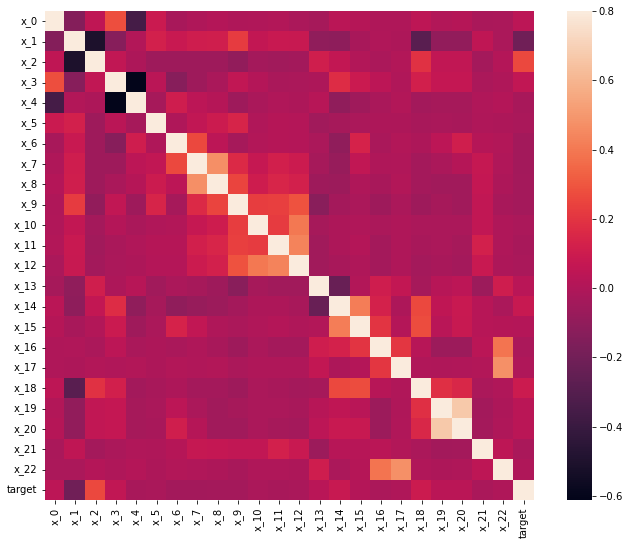

In [10]:
corrmat = all_data.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, ax=ax);

Явно выраженной корреляции с целевой переменной не наблюдается, кроме колонки x_1. Также по данному графику можно сказать, что наблюдается взаимная корреляция между:
- x_0 и x_4
- x_1 и x_2
- x_3 и x_4
- x_19 и x_20
- x_17 и x_22

Взаимная корреляция оказывает негативное влияние на линейные модели. Для решения данной проблемы можно пойти двумя путями: удалить коррелирующие колонки или воспользоваться регуляризацией (в случае дисбаланса классов регуляризация также необходима).

Также построим pairplot для дополнительного анализа колонок (выполнено отдельно с помощью скрипта plot_pairplot.py, здесь выведен результат в виде картинки).

<img src="images/pair_plot.png"></img>

Что можно сказать по данному pairplot:
- x_1, x_4, x_17 - категориальные фичи. Хотя x_17 и имеет 19 уникальных значений, по факту эти уникальные значения можно объединить в 5 категорий (см. pairplot)
- x_1 имеет 8 уникальных значений, но всего один объект имеет одно из этих уникальных значений - его можно удалить
- x_20 имеет объект выброс (единственный), который также необходимо удалить. Он увеличит смещение модели. То же самое можно сказать и про x_10 (возможно это один и тот же объект)
- x_3 визуально бьется на два кластера - все, что выше 0.2 и все что ниже 0.2. В значениях выше отсутствую объекты класса 1. Возможно, стоит заменить эту колонку на бинарную фичу, либо удалить те объекты, значения которых превышают 0.2
- x_7 имеет объекты, превышающие значение 300. Похоже на выбросы и чтобы избавится от смещения модели - удалим их
- x_9 также имеет выбросы сверху, которые можно удалить. То же самое можно сказать и про x_11, x_13, x_15, x_16, x_21
- также интересная картина наблюдается на пересечении x_22 и x_13. Как будто наблюдается два класса - "вертикальный", колеблющийся в небольшой окресности значения x_13, и "горизонтальный", колеблющийся в районе x_22 == 0. Возможно, стоит добавить дополнительную фичу, соответствующую этим двум классам.

## Предподготовка данных

In [368]:
prepared_data = all_data.copy()

**Заполнение пропусков**

Заполним пропуски нулями

In [369]:
prepared_data = prepared_data.fillna(value=0)

**Уменьшение количества категорий для переменной x_17**

In [370]:
km_train = prepared_data['x_17'].values.reshape(-1, 1)
km = KMeans(n_clusters=5).fit(km_train)
prepared_data['x_17_cluster'] = km.predict(km_train)

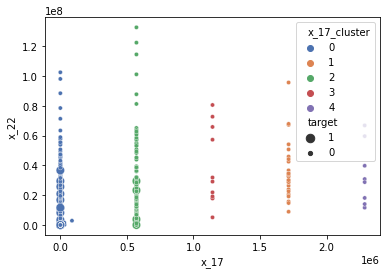

In [371]:
sns.scatterplot(
    data=prepared_data, x='x_17', y='x_22', hue='x_17_cluster', palette='deep', size='target', size_order=[1, 0]);

In [372]:
prepared_data = prepared_data.drop('x_17', axis='columns')
prepared_data = prepared_data.rename(columns={'x_17_cluster': 'x_17'})

**Удаление выброса в колонке x_1**

In [373]:
idx_drop = prepared_data[prepared_data['x_1'] > prepared_data['x_1'].quantile(0.9)].index
prepared_data = prepared_data.drop(idx_drop, axis='rows')

**Удаление выброса в x_10, x_12 и x_20**

In [374]:
idx_drop = prepared_data[prepared_data['x_10'] >= prepared_data['x_10'].max()].index
prepared_data = prepared_data.drop(idx_drop, axis='rows')

idx_drop = prepared_data[prepared_data['x_12'] >= prepared_data['x_12'].max()].index
prepared_data = prepared_data.drop(idx_drop, axis='rows')

idx_drop = prepared_data[prepared_data['x_20'] >= prepared_data['x_20'].max()].index
prepared_data = prepared_data.drop(idx_drop, axis='rows')

**Добавление кластера в x_3**

In [375]:
prepared_data['x_3_cluster'] = (prepared_data['x_3'] >= 0.2).astype('uint8')

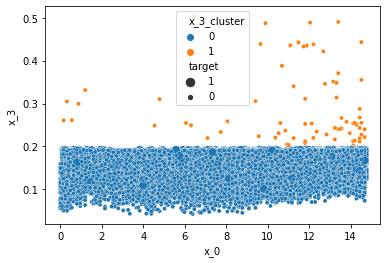

In [376]:
sns.scatterplot(
    data=prepared_data, x='x_0', y='x_3', hue='x_3_cluster', size='target', size_order=[1, 0]);

**Удаление выбросов в x_7**

In [377]:
q1 = prepared_data['x_7'].quantile(0.25)
q3 = prepared_data['x_7'].quantile(0.75)
iqr = q3 - q1

idx_drop = prepared_data[prepared_data['x_7'] > (q3 + 1.5 * iqr)].index
prepared_data = prepared_data.drop(idx_drop, axis='rows')

**Кластеризация x_13 / x_22**

In [378]:
prepared_data['x_13_x_22_clusters'] = (prepared_data['x_22'] > 1e6).astype('uint8')

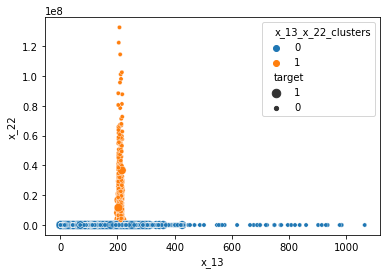

In [379]:
sns.scatterplot(
    data=prepared_data, x='x_13', y='x_22', hue='x_13_x_22_clusters', size='target', size_order=[1, 0]);

**Логарифмирование фичей**

Выбросы в x_11, x_12, x_13 и прочих удалять не будем. Решим проблему выбросов с помощью логарифмирования, чтобы привести распределение фичей к нормальному виду.

In [380]:
features_to_log = ['x_5', 'x_6', 'x_9', 'x_10', 'x_11', 'x_12', 'x_14', 'x_16', 'x_19', 'x_21', 'x_22']
for feature in features_to_log:
    prepared_data[features_to_log] = np.log1p(prepared_data[features_to_log])

**Обработка нулевых значений**

Нулевые значения по сути своей являются выбросами. Неплохо бы их для некоторых колонок заменить медианой, при этом оставив признак, что это значение было нулевым. Сделаем это для следующих колонок:
```python
['x_8', 'x_9', 'x_10', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22']
```

In [381]:
zeros_features = ['x_8', 'x_9', 'x_10', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22']
for feature in zeros_features:
    prepared_data['{}_is_zero'.format(feature)] = (prepared_data[feature] == 0).astype('uint8')
    prepared_data.loc[prepared_data[feature] == 0, feature] = prepared_data.loc[
        prepared_data[feature] != 0, feature].median()

**Кодирование категориальных переменных**

К категориальным относятся три колонки:
```python
['x_1', 'x_4', 'x_17']
```

Закодируем их с помощью one hot метода

In [382]:
encoder = LabelEncoder()
cat_features = ['x_1', 'x_4', 'x_17']
for cat_feature in cat_features:
    prepared_data[cat_feature] = encoder.fit_transform(prepared_data[cat_feature])
    prepared_data[cat_feature] = prepared_data[cat_feature].astype('str')
    
dummies = pd.get_dummies(prepared_data[cat_features])
prepared_data = pd.concat([prepared_data, dummies], axis='columns')
prepared_data = prepared_data.drop(cat_features, axis='columns')

**Нормализация данных**

Для градиентного спуска данные должны иметь одинаковый масштаб. Сделаем это с помощью MinMaxScaler (кроме категориальных фичей).

In [383]:
num_features = [
    'x_0', 'x_2', 'x_3', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11',
    'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_18', 'x_19', 'x_20', 'x_21',
    'x_22'
]
scaler = MinMaxScaler()
prepared_data.loc[:, num_features] = scaler.fit_transform(prepared_data[num_features])

**Разбиение на train / test**

In [424]:
x_train, x_test, y_train, y_test = train_test_split(
    prepared_data.drop('target', axis='columns'), prepared_data['target'], train_size=0.85, 
    stratify=prepared_data['target'], random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((31542, 51), (5567, 51), (31542,), (5567,))

**Решение проблемы дисбаланса классов**

Попробуем решить проблему дисбаланса классов с помощью SMOTE метода

In [417]:
# sm = SMOTE()
# x_train, y_train = sm.fit_resample(x_train, y_train)

# x_train.shape, y_train.shape

((61946, 51), (61946,))

Метод показал себя не лучшим образом

# Построение моделей

Самое идеальное - получить метрику качества Precision == 1 и более менее весомый recall. То есть все те объекты, которые мы предсказали с классом 1, действительно являются объектами первого класса (т.е. все те, кому мы отказали в кредите, действительно не смогут его выплатить), и предсказать существенную часть объектов 1-го класса (т.е. пропустить небольшое число неплатежоспособных клиентов). Это делается с целью не терять выручку банка.

## Константное предсказание (baseline)

В качестве baseline модели, качество которой мы в последствии хотим улучшить, будем использовать константное предсказание - модель всегда будет возвращать 0 (т.е. клиент кредитоспособен).

In [425]:
class BaselineModel:
    def __init__(self):
        pass
        
    def predict(self, data: Union[np.array, pd.DataFrame]) -> np.array:
        return np.zeros(shape=(data.shape[0], ))
    
    def predict_proba(self, y_true: Union[np.array, pd.DataFrame]) -> np.array:
        return np.stack(
                   (
                       np.full(shape=(y_true.shape[0], ), fill_value=y_true.mean()), 
                       np.full(shape=(y_true.shape[0], ), fill_value=1 - y_true.mean())
                   ), axis=1)

**Оценка качества**

In [427]:
baseline_model = BaselineModel()
y_hat_test = baseline_model.predict(data=x_test)


acc_test = accuracy_score(y_true=y_test, y_pred=y_hat_test)
precision_test = precision_score(y_true=y_test, y_pred=y_hat_test)
recall_test = recall_score(y_true=y_test, y_pred=y_hat_test)
roc_auc_test = roc_auc_score(y_true=y_test, y_score=baseline_model.predict_proba(y_true=y_test)[:, 0])

print('Accuracy:')
print('Test:\t{:.2f}'.format(acc_test))

print('\nPrecision:')
print('Test:\t{:.2f}'.format(precision_test))

print('\nRecall:')
print('Test:\t{:.2f}'.format(recall_test))

print('\nROC AUC:')
print('Test:\t{:.2f}'.format(roc_auc_test))

Accuracy:
Test:	0.98

Precision:
Test:	0.00

Recall:
Test:	0.00

ROC AUC:
Test:	0.50


Очевидно, что recall равен 0, т.к. наша базовая модель всегда предсказывает 0 на всех объектах. В случае, когда у нас ROC AUC равно 0.5, можно сказать, что наша модель не имеет предсказательной силы.

## LogLoss

Посмотрим, как справится с решением данной задачи простейшая линейная модель

**Обучение модели**

In [428]:
params = {
    'solver':['lbfgs', 'liblinear'], 
    'C': [1e-2, 1e-1, 1, 10, 100, 200],
    'class_weight': [None, {0: 0.1, 1: 0.9}, {0: 0.05, 1: 0.95}, {0: 0.01, 1: 0.99}]
}

log_reg = LogisticRegression()
cls = GridSearchCV(estimator=log_reg, param_grid=params, scoring='roc_auc', verbose=1)
cls.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 200],
                         'class_weight': [None, {0: 0.1, 1: 0.9},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.01, 1: 0.99}],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=1)

In [429]:
cls.best_estimator_

LogisticRegression(C=100, class_weight={0: 0.05, 1: 0.95})

**Оценка качества**

In [430]:
y_hat_train, y_hat_test = cls.predict(x_train), cls.predict(x_test)
y_hat_train_proba, y_hat_test_proba = cls.predict_proba(x_train), cls.predict_proba(x_test)

acc_train, acc_test = accuracy_score(
    y_true=y_train, y_pred=y_hat_train), accuracy_score(y_true=y_test, y_pred=y_hat_test)
precision_train, precision_test = precision_score(
    y_true=y_train, y_pred=y_hat_train), precision_score(y_true=y_test, y_pred=y_hat_test)
recall_train, recall_test = recall_score(
    y_true=y_train, y_pred=y_hat_train), recall_score(y_true=y_test, y_pred=y_hat_test)
auc_train, auc_test = roc_auc_score(
    y_true=y_train, y_score=y_hat_train_proba[:, 1]), roc_auc_score(y_true=y_test, y_score=y_hat_test_proba[:, 1])

print('Accuracy:')
print('Train:\t{:.2f}'.format(acc_train))
print('Test:\t{:.2f}'.format(acc_test))

print('\nPrecision:')
print('Train:\t{:.2f}'.format(precision_train))
print('Test:\t{:.2f}'.format(precision_test))

print('\nRecall:')
print('Train:\t{:.2f}'.format(recall_train))
print('Test:\t{:.2f}'.format(recall_test))

print('\nROC AUC:')
print('Train:\t{:.2f}'.format(auc_train))
print('Test:\t{:.2f}'.format(auc_test))

Accuracy:
Train:	0.92
Test:	0.92

Precision:
Train:	0.12
Test:	0.13

Recall:
Train:	0.53
Test:	0.57

ROC AUC:
Train:	0.87
Test:	0.87


**Features importance**

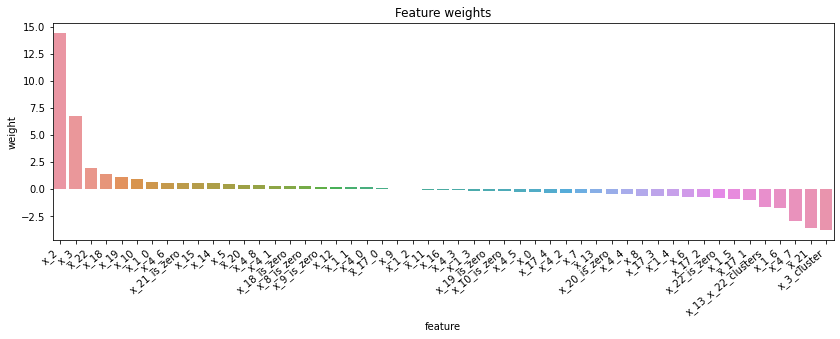

In [431]:
feature_importance = pd.DataFrame(data={
    'feature': x_train.columns,'weight': cls.best_estimator_.coef_.flatten()})
feature_importance = feature_importance.sort_values(by='weight', ascending=False)

fig, ax = plt.subplots(figsize=(14, 4))
sns.barplot(data=feature_importance, x="feature", y="weight", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Feature weights')
fig.show()

## CatBoost

In [432]:
train_pool = Pool(data=x_train, label=y_train)
test_pool = Pool(data=x_test, label=y_test)

**Обучение модели**

In [440]:
catboost_cls = CatBoostClassifier(
    iterations=2000, 
    learning_rate=0.01,
    max_depth=2, 
    eval_metric='Logloss', 
    l2_leaf_reg=None,
    auto_class_weights='SqrtBalanced')
catboost_cls.fit(train_pool, eval_set=test_pool, plot=True, early_stopping_rounds=50, verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6825324	test: 0.6824905	best: 0.6824905 (0)	total: 17.5ms	remaining: 35s
100:	learn: 0.3117851	test: 0.3079422	best: 0.3079422 (100)	total: 1.65s	remaining: 31.1s
200:	learn: 0.2695552	test: 0.2645570	best: 0.2645570 (200)	total: 3.52s	remaining: 31.5s
300:	learn: 0.2588254	test: 0.2537609	best: 0.2537609 (300)	total: 5.42s	remaining: 30.6s
400:	learn: 0.2539789	test: 0.2489439	best: 0.2489439 (400)	total: 7.14s	remaining: 28.5s
500:	learn: 0.2510243	test: 0.2462795	best: 0.2462795 (500)	total: 8.79s	remaining: 26.3s
600:	learn: 0.2487964	test: 0.2448441	best: 0.2448305 (595)	total: 10.5s	remaining: 24.4s
700:	learn: 0.2469301	test: 0.2438002	best: 0.2438002 (700)	total: 12.2s	remaining: 22.6s
800:	learn: 0.2454116	test: 0.2431583	best: 0.2431583 (800)	total: 14s	remaining: 21s
900:	learn: 0.2438790	test: 0.2426974	best: 0.2426974 (900)	total: 16.1s	remaining: 19.6s
1000:	learn: 0.2424131	test: 0.2424111	best: 0.2424111 (1000)	total: 17.9s	remaining: 17.9s
Stopped by overfi

**Оценка качества модели**

In [441]:
y_hat_train, y_hat_test = catboost_cls.predict(x_train), catboost_cls.predict(x_test)
y_hat_train_proba, y_hat_test_proba = catboost_cls.predict_proba(x_train), catboost_cls.predict_proba(x_test)

acc_train, acc_test = accuracy_score(
    y_true=y_train, y_pred=y_hat_train), accuracy_score(y_true=y_test, y_pred=y_hat_test)
precision_train, precision_test = precision_score(
    y_true=y_train, y_pred=y_hat_train), precision_score(y_true=y_test, y_pred=y_hat_test)
recall_train, recall_test = recall_score(
    y_true=y_train, y_pred=y_hat_train), recall_score(y_true=y_test, y_pred=y_hat_test)
auc_train, auc_test = roc_auc_score(
    y_true=y_train, y_score=y_hat_train_proba[:, 1]), roc_auc_score(y_true=y_test, y_score=y_hat_test_proba[:, 1])

print('Accuracy:')
print('Train:\t{:.2f}'.format(acc_train))
print('Test:\t{:.2f}'.format(acc_test))

print('\nPrecision:')
print('Train:\t{:.2f}'.format(precision_train))
print('Test:\t{:.2f}'.format(precision_test))

print('\nRecall:')
print('Train:\t{:.2f}'.format(recall_train))
print('Test:\t{:.2f}'.format(recall_test))

print('\nROC AUC:')
print('Train:\t{:.2f}'.format(auc_train))
print('Test:\t{:.2f}'.format(auc_test))

Accuracy:
Train:	0.97
Test:	0.97

Precision:
Train:	0.23
Test:	0.24

Recall:
Train:	0.38
Test:	0.42

ROC AUC:
Train:	0.89
Test:	0.89


**Features importance**

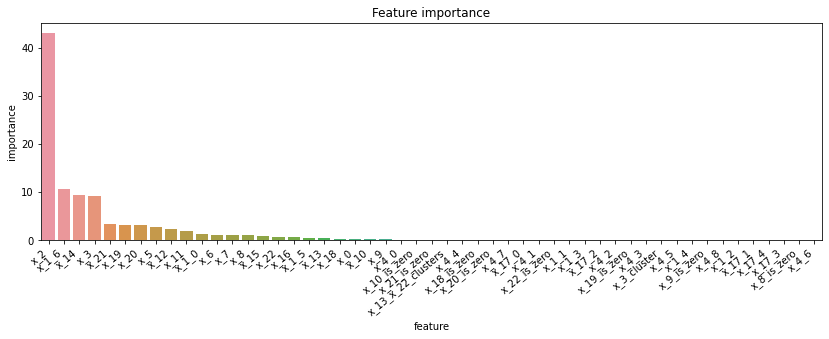

In [447]:
feature_importance = pd.DataFrame(data={
    'feature': catboost_cls.feature_names_,'importance': catboost_cls.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(14, 4))
sns.barplot(data=feature_importance, x="feature", y="importance", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Feature importance')
fig.show()

# Подбор порога